In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_image(path):
    img = Image.open(path)
    img_arr = np.array(img)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(img_arr, (0, 1, 2)))


In [2]:
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


transformations = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

total_dataset = datasets.ImageFolder("flowers", transform = transformations)
dataset_loader = DataLoader(dataset = total_dataset, batch_size = 100)
items = iter(dataset_loader)
image, label = items.next()

In [3]:
 num_classes = len(total_dataset.classes)
num_classes

5

In [4]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


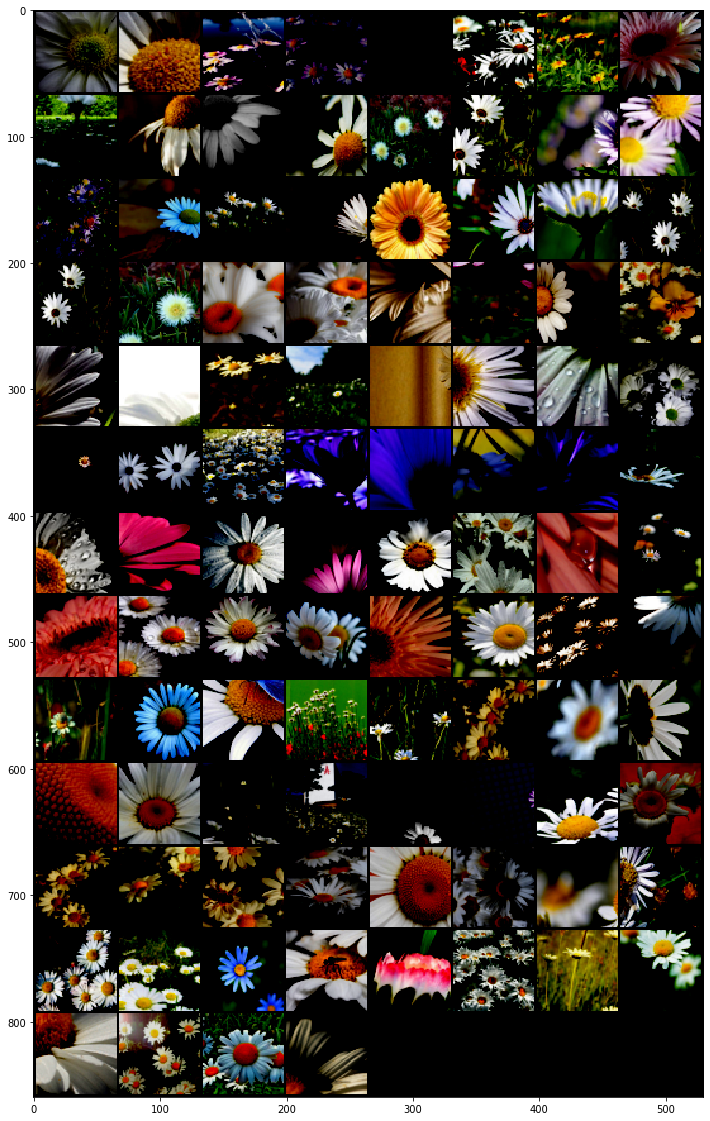

In [5]:
show_transformed_image(make_grid(image))


In [6]:
from torch.utils.data import random_split

train_size = int(0.8 * len(total_dataset))
test_size = len(total_dataset) - train_size
train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size])

train_dataset_loader = DataLoader(dataset = train_dataset, batch_size = 100)
test_dataset_loader = DataLoader(dataset = test_dataset, batch_size = 100)

In [7]:
import torch.nn as nn

class FlowerClassifierCNNModel(nn.Module):
    
    def __init__(self, num_classes=5):
        super(FlowerClassifierCNNModel,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3,stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.lf = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
    
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        
        output = self.maxpool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        
        output = output.view(-1, 32 * 32 * 24)

        output = self.lf(output)

        return output

In [8]:
# from torch.optim import Adam

# cnn_model = FlowerClassifierCNNModel()
# cnn_model.to(device)
# optimizer = Adam(cnn_model.parameters())
# loss_fn = nn.CrossEntropyLoss()

cnn_model = FlowerClassifierCNNModel()
cnn_model.load_state_dict(torch.load('flowermodel'))
cnn_model.to(device)

FlowerClassifierCNNModel(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (lf): Linear(in_features=24576, out_features=5, bias=True)
)

In [9]:

def getImageClassName(sdfds):
    test_image = Image.open(sdfds)
    test_image_tensor = transformations(test_image).float()
    test_image_tensor = test_image_tensor.unsqueeze_(0)
    test_image_tensor = test_image_tensor.to(device)
    output = cnn_model(test_image_tensor)
    output.data.cpu().numpy().argmax()
    return total_dataset.classes[output.data.cpu().numpy().argmax()].capitalize()

In [10]:
def train_and_build(n_epoches):
    tl=0
    x=[]
    y=[]
    for epoch in range(n_epoches):
        cnn_model.train()
        for i, data in enumerate(train_dataset_loader):
            (images, labels) = data[0].to(device),data[1].to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss = loss.item()
            tl+=running_loss
            if i % 10 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
        x.append(epoch)
        y.append(tl)
        tl=0
        plt.plot(x, y)     

In [11]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    
    test_image = Image.open(image_name)
    test_image_tensor = transformations(test_image).float()
    test_image_tensor = test_image_tensor.unsqueeze_(0)
    test_image_tensor = test_image_tensor.to(device)

    t_img = test_image_tensor
    
    df = cnn_model(t_img)

    return df



def getCosSimi(pic_one_vector,pic_two_vector):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_sim = cos(pic_one_vector,
                  pic_two_vector)
    return cos_sim.tolist()[0]



def getListOfSlrImges(chooseImage):
    pic_one_vector = get_vector(chooseImage)

    listOfImages = []

    for folder in os.listdir('flowers'):
        for filename in os.listdir(os.path.join('flowers', folder)):
            pic_two_vector = get_vector(os.path.join('flowers', folder,filename) )
            #print(os.path.join('flowers', folder,filename))
            if getCosSimi(pic_one_vector,pic_two_vector) > 0.98:
                listOfImages.append((os.path.join('flowers', folder,filename)))
    return listOfImages



[1,     1] loss: 1.602
[1,    11] loss: 1.467
[1,    21] loss: 1.336
[1,    31] loss: 1.301
[2,     1] loss: 1.175
[2,    11] loss: 1.246
[2,    21] loss: 1.191
[2,    31] loss: 1.191
[3,     1] loss: 1.265
[3,    11] loss: 1.020
[3,    21] loss: 1.068
[3,    31] loss: 1.105
[4,     1] loss: 1.087
[4,    11] loss: 0.994
[4,    21] loss: 1.139
[4,    31] loss: 1.114
[5,     1] loss: 1.107
[5,    11] loss: 0.964
[5,    21] loss: 1.159
[5,    31] loss: 1.046
[6,     1] loss: 1.137
[6,    11] loss: 0.920
[6,    21] loss: 1.193
[6,    31] loss: 1.021
[7,     1] loss: 1.025
[7,    11] loss: 0.930
[7,    21] loss: 1.136
[7,    31] loss: 0.991
[8,     1] loss: 1.082
[8,    11] loss: 0.867
[8,    21] loss: 1.071
[8,    31] loss: 1.021
[9,     1] loss: 1.108
[9,    11] loss: 0.870
[9,    21] loss: 1.090
[9,    31] loss: 0.935
[10,     1] loss: 0.966
[10,    11] loss: 1.003
[10,    21] loss: 1.118
[10,    31] loss: 1.002
[11,     1] loss: 0.881
[11,    11] loss: 0.870
[11,    21] loss: 1.032
[11,

[86,    31] loss: 0.693
[87,     1] loss: 0.648
[87,    11] loss: 0.596
[87,    21] loss: 1.045
[87,    31] loss: 0.654
[88,     1] loss: 0.692
[88,    11] loss: 0.497
[88,    21] loss: 0.925
[88,    31] loss: 0.667
[89,     1] loss: 0.731
[89,    11] loss: 0.621
[89,    21] loss: 0.874
[89,    31] loss: 0.737
[90,     1] loss: 0.733
[90,    11] loss: 0.529
[90,    21] loss: 0.813
[90,    31] loss: 0.678
[91,     1] loss: 0.751
[91,    11] loss: 0.621
[91,    21] loss: 0.885
[91,    31] loss: 0.666
[92,     1] loss: 0.715
[92,    11] loss: 0.464
[92,    21] loss: 0.763
[92,    31] loss: 0.730
[93,     1] loss: 0.644
[93,    11] loss: 0.552
[93,    21] loss: 0.754
[93,    31] loss: 0.813
[94,     1] loss: 0.688
[94,    11] loss: 0.686
[94,    21] loss: 0.822
[94,    31] loss: 0.736
[95,     1] loss: 0.684
[95,    11] loss: 0.526
[95,    21] loss: 0.799
[95,    31] loss: 0.683
[96,     1] loss: 0.706
[96,    11] loss: 0.638
[96,    21] loss: 0.793
[96,    31] loss: 0.753
[97,     1] loss

[169,    11] loss: 0.553
[169,    21] loss: 0.695
[169,    31] loss: 0.653
[170,     1] loss: 0.733
[170,    11] loss: 0.548
[170,    21] loss: 0.706
[170,    31] loss: 0.645
[171,     1] loss: 0.804
[171,    11] loss: 0.511
[171,    21] loss: 0.749
[171,    31] loss: 0.536
[172,     1] loss: 0.725
[172,    11] loss: 0.480
[172,    21] loss: 0.862
[172,    31] loss: 0.599
[173,     1] loss: 0.684
[173,    11] loss: 0.504
[173,    21] loss: 0.686
[173,    31] loss: 0.676
[174,     1] loss: 0.710
[174,    11] loss: 0.561
[174,    21] loss: 0.675
[174,    31] loss: 0.612
[175,     1] loss: 0.646
[175,    11] loss: 0.574
[175,    21] loss: 0.787
[175,    31] loss: 0.599
[176,     1] loss: 0.601
[176,    11] loss: 0.517
[176,    21] loss: 0.693
[176,    31] loss: 0.627
[177,     1] loss: 0.645
[177,    11] loss: 0.483
[177,    21] loss: 0.760
[177,    31] loss: 0.615
[178,     1] loss: 0.636
[178,    11] loss: 0.485
[178,    21] loss: 0.740
[178,    31] loss: 0.713
[179,     1] loss: 0.701


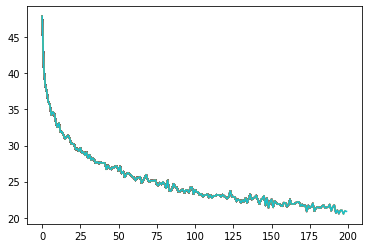

In [98]:
train_and_build(200)

In [12]:
# torch.save(cnn_model, 'newmodel.pth')
 
net=torch.load('newmodel.pth') 
net.eval()

print(net)

FlowerClassifierCNNModel(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (lf): Linear(in_features=24576, out_features=5, bias=True)
)


In [13]:
import torch

cnn_model.eval()
test_acc_count = 0
for k, data in enumerate(test_dataset_loader):
    (test_images, test_labels) = data[0].to(device),data[1].to(device)
    test_outputs = cnn_model(test_images)
    _, prediction = torch.max(test_outputs.data, 1)
    test_acc_count += torch.sum(prediction == test_labels.data).item()

test_accuracy = test_acc_count*100 / len(test_dataset)

In [14]:
test_accuracy

79.88439306358381

In [15]:
test_image = Image.open("rose.jpeg")
test_image_tensor = transformations(test_image).float()
test_image_tensor = test_image_tensor.unsqueeze_(0)
test_image_tensor = test_image_tensor.to(device)
output = cnn_model(test_image_tensor)

output.data.cpu().numpy().argmax()
# class_index = output.data.numpy().argmax()


# from PIL import Image
 
# def image_loader(loader, image_name):
#     image = Image.open(image_name)
#     image = loader(image).float()
#     image = torch.tensor(image, requires_grad=True)
#     image = image.unsqueeze(0)
#     image = image.to(device)
    
#     return image



# outputs = net(image_loader(transformations, 'rose-flower-500x500.jpg'))
# _, predicted = torch.max(outputs.data, 1)
# predicted.tolist()[0]     

total_dataset.classes[output.data.cpu().numpy().argmax()]


'rose'

In [16]:
torch.save(cnn_model.state_dict(), 'flowermodel')

In [17]:
cnn_model = FlowerClassifierCNNModel()
cnn_model.load_state_dict(torch.load('flowermodel'))
cnn_model.to(device)

FlowerClassifierCNNModel(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (lf): Linear(in_features=24576, out_features=5, bias=True)
)

# dsf

/home/joshi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


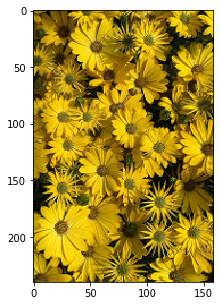

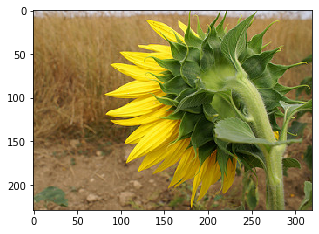

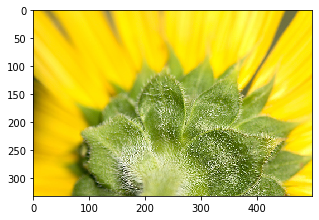

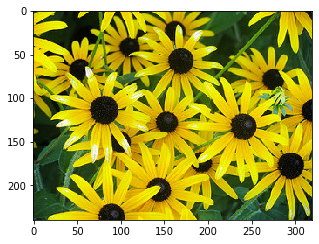

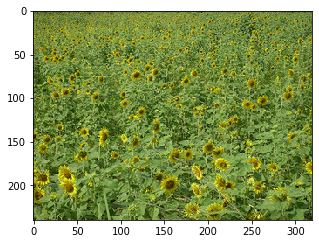

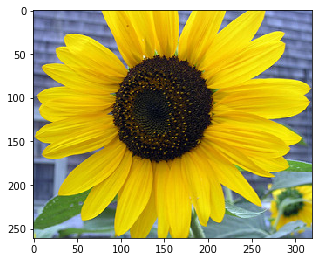

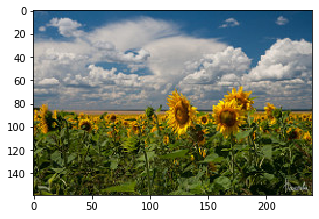

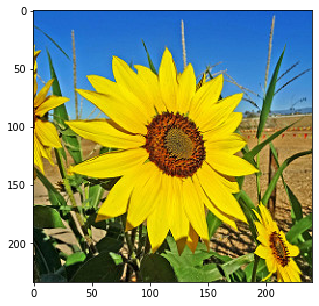

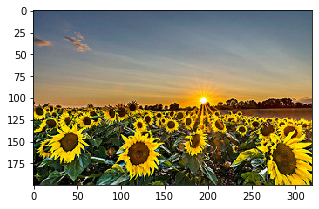

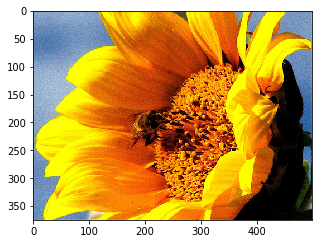

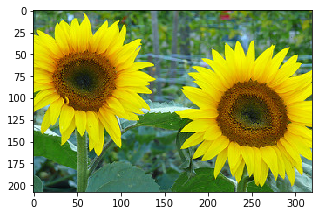

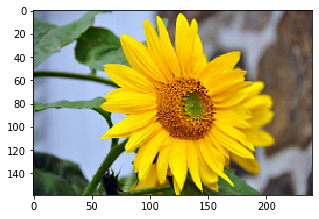

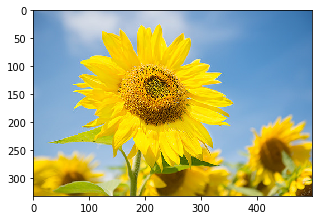

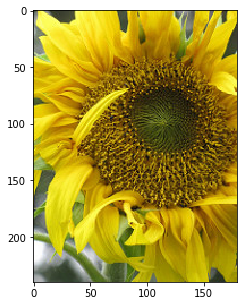

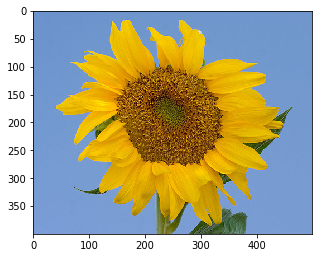

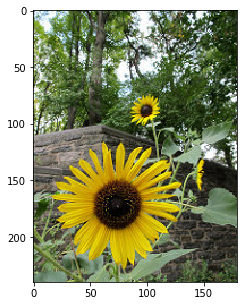

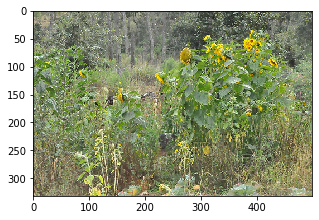

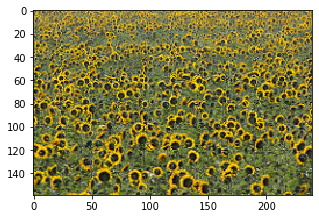

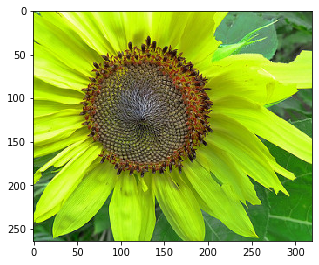

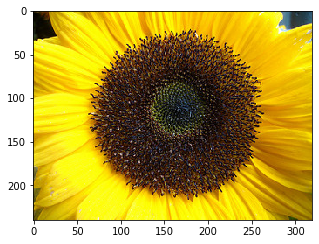

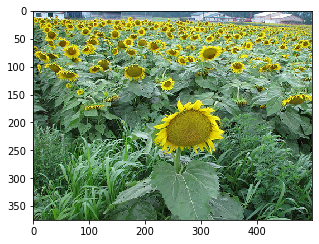

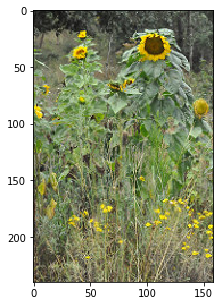

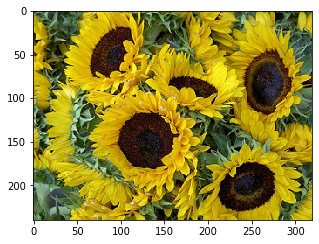

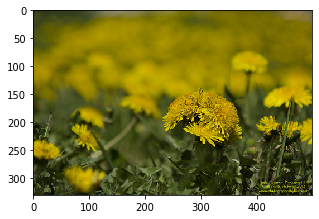

In [18]:
#for getting top images 
from PIL import Image
from torch.autograd import Variable



cnn_model.eval()
cnn_model.to(device)



def get_vector(image_name):
    # 1. Load the image with Pillow library
    
    test_image = Image.open(image_name)
    test_image_tensor = transformations(test_image).float()
    test_image_tensor = test_image_tensor.unsqueeze_(0)
    test_image_tensor = test_image_tensor.to(device)

    t_img = test_image_tensor
    
    df = cnn_model(t_img)

    return df


def getCosSimi(pic_one_vector,pic_two_vector):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_sim = cos(pic_one_vector,
                  pic_two_vector)
    return cos_sim.tolist()[0]


import os

chooseImage = 'flowers//sunflower//44079668_34dfee3da1_n.jpg'
pic_one_vector = get_vector(chooseImage)

for folder in os.listdir('flowers'):
    for filename in os.listdir(os.path.join('flowers', folder)):
        pic_two_vector = get_vector(os.path.join('flowers', folder,filename) )
        #print(os.path.join('flowers', folder,filename))
        if getCosSimi(pic_one_vector,pic_two_vector) > 0.98:
            show_image(os.path.join('flowers', folder,filename))
        

In [ ]:
from tkinter import *
from tkinter import filedialog
from tkinter.ttk import *
import tkinter.messagebox as messagebox
from PIL import ImageTk, Image
import os

#from tkinter.filedialog import askopenfilename,ask


window = Tk()
window.title("Welcome to Neural Style Transfer")






# image = PhotoImage(file="intro.gif")
# label = Label(image=image)
# label.grid(row=0,column=0)


def selectContentFile():
    filename = filedialog.askopenfilename(initialdir='C:/Users/ashish/Machine Learning Noida')
    if filename != "":
        if filename.endswith('jpg') or filename.endswith('jpeg') or filename.endswith('png'):
            txt.delete(0,END)
            txt.insert(0,filename)   
            
            
            content_image = Image.open(txt.get())
            resized = content_image.resize(( int(content_image.width*0.75), int(content_image.height*0.75) ), Image.ANTIALIAS)
            content_photo = ImageTk.PhotoImage(resized)
            content_label.configure(image=content_photo)
#             content_label = Label(image=content_photo)
            content_label.image = content_photo # keep a reference!
            content_label.grid(row =1, column =1,pady=(20,20))
            

            


    
def applyStyle():
    
    
    if(txt.get()=='' ):
        messagebox.showerror("Error", "Please Fill All the Boxes")
    else:
        sdf = getImageClassName(txt.get())
        sdf = 'It is a '+sdf
        lbl2.config(text=sdf)
        lis = getListOfSlrImges(txt.get())
        lis = lis[:6]
        COLUMNS = 3
        image_count = 0
        for infile in lis:
            infile.replace("\\","/")
            print(infile)
            if infile in txt.get():
                continue
            image_count += 1
            r, c = divmod(image_count-1, COLUMNS)
            im = Image.open(infile )
            im = im.resize((150,150))
            cp = ImageTk.PhotoImage(im)
            cl = Label(image=cp)
            cl.image = cp # keep a reference!
            cl.grid(row=r+5, column=c)
            r=r+1
        
    
    
    
    

    
#Selecting the content image
            
lbl = Label(window, text=" Your Content Image: ")
lbl.grid(column=0, row=0,pady=(5,6))

txt = Entry(window,width=75)
txt.grid(column=1, row=0,pady=(5,6))


btn = Button(window, text="Select File", command=selectContentFile)
btn.grid(column=2, row=0, padx=(10,10))




# bg="#51CCE0",fg="#FFFFFF",font=("Arial Bold", 13),



 
    


content_image = Image.open("rose.jpg")
resized = content_image.resize(( int(content_image.width*0.75), int(content_image.height*0.75) ), Image.ANTIALIAS)

content_photo = ImageTk.PhotoImage(resized)
content_label = Label(image=content_photo)
content_label.image = content_photo # keep a reference!
content_label.grid(row =1, column =1,pady=(20,20))



 


# img = ImageTk.PhotoImage(Image.open("images_tkinter/udnie.gif"))
# panel = Label(window, image = img)
# panel.grid(row=4,column=1)

# on change dropdown value

        
    
btn2 = Button(window, text="Apply", command=applyStyle)
btn2.grid(column=1, row=2)

lbl2 = Label(window, text="")
lbl2.grid(column=1, row=3,pady=(20,20))



    




window.mainloop()

flowers/rose/7456196534_f69c17efa3_n.jpg
flowers/rose/33411423082_8150d9254e_n.jpg
flowers/rose/9423755543_edb35141a3_n.jpg
flowers/rose/2888138918_402096c7fb.jpg
flowers/rose/7461899002_a3b21d0770_n.jpg
flowers/rose/7376473742_532364cee5_n.jpg
flowers/rose/19027407015_141c10ddcb_n.jpg
flowers/rose/5979193298_639e877248.jpg
flowers/rose/5002458392_f465ed905e_n.jpg
flowers/rose/5628552852_60bbe8d9b0_n.jpg
flowers/rose/3526860692_4c551191b1_m.jpg
flowers/daisy/519880292_7a3a6c6b69.jpg
